<a href="https://colab.research.google.com/github/AK18k/ex2_1/blob/avis_lab/ex2_latenight.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
!git clone -b avis_lab https://github.com/AK18k/ex2_1



Cloning into 'ex2_1'...
remote: Enumerating objects: 98, done.
remote: Counting objects: 100% (98/98), done.
remote: Compressing objects: 100% (95/95), done.
remote: Total 98 (delta 45), reused 2 (delta 0), pack-reused 0
Unpacking objects: 100% (98/98), 2.22 MiB | 1.85 MiB/s, done.


In [16]:
import os
from google.colab import drive
#drive.mount('/content/drive')
DATA_PATH = '/content/ex2_1/data/ptb'
PATH = '/content/ex2_1'
os.chdir('/content/ex2_1')
!ls

data  ex2_1  ex2_latenight.ipynb  main.ipynb  README.md


In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import numpy as np


In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device is {device}')

device is cuda


In [19]:
import os
import torch

from collections import Counter


class Dictionary(object):
    def __init__(self):
        self.word2idx = {}
        self.idx2word = []
        self.counter = Counter()
        self.total = 0

    def add_word(self, word):
        if word not in self.word2idx:
            self.idx2word.append(word)
            self.word2idx[word] = len(self.idx2word) - 1
        token_id = self.word2idx[word]
        self.counter[token_id] += 1
        self.total += 1
        return self.word2idx[word]

    def __len__(self):
        return len(self.idx2word)


class Corpus(object):
    def __init__(self, path):
        self.dictionary = Dictionary()
        self.train = self.tokenize(os.path.join(path, 'train.txt'))
        self.valid = self.tokenize(os.path.join(path, 'valid.txt'))
        self.test = self.tokenize(os.path.join(path, 'test.txt'))

    def tokenize(self, path):
        """Tokenizes a text file."""
        assert os.path.exists(path)
        # Add words to the dictionary
        with open(path, 'r') as f:
            tokens = 0
            for line in f:
                words = line.split() + ['<eos>']
                tokens += len(words)
                for word in words:
                    self.dictionary.add_word(word)

        # Tokenize file content
        with open(path, 'r') as f:
            ids = torch.LongTensor(tokens)
            token = 0
            for line in f:
                words = line.split() + ['<eos>']
                for word in words:
                    ids[token] = self.dictionary.word2idx[word]
                    token += 1

        return ids


In [32]:
# Get first 100 words

for word_index in range(100):
  print(f'word index = {word_index}, word = {corpus.dictionary.idx2word[word_index]}')

word index = 0, word = aer
word index = 1, word = banknote
word index = 2, word = berlitz
word index = 3, word = calloway
word index = 4, word = centrust
word index = 5, word = cluett
word index = 6, word = fromstein
word index = 7, word = gitano
word index = 8, word = guterman
word index = 9, word = hydro-quebec
word index = 10, word = ipo
word index = 11, word = kia
word index = 12, word = memotec
word index = 13, word = mlx
word index = 14, word = nahb
word index = 15, word = punts
word index = 16, word = rake
word index = 17, word = regatta
word index = 18, word = rubens
word index = 19, word = sim
word index = 20, word = snack-food
word index = 21, word = ssangyong
word index = 22, word = swapo
word index = 23, word = wachter
word index = 24, word = <eos>
word index = 25, word = pierre
word index = 26, word = <unk>
word index = 27, word = N
word index = 28, word = years
word index = 29, word = old
word index = 30, word = will
word index = 31, word = join
word index = 32, word = th

In [20]:
import math
import numpy as np
import matplotlib.pyplot as plt

class Result_Matrix:
    def __init__(self, model_type):
      self.model_name = model_type
      self.nepochs = 0
      self.train_ppl = np.array([])
      self.val_ppl = np.array([])
      self.test_ppl = np.array([])

    def add_result(self, result, result_type = 'train'):
      if result_type == 'train':
        self.train_ppl = np.append(self.train_ppl, result)
      elif result_type == 'val':
        self.val_ppl = np.append(self.val_ppl, result)
      elif result_type == 'test':
        self.test_ppl = np.append(self.test_ppl, result)

    def get_results(self, result_type = 'train'):
      if result_type == 'train':
        return(self.train_ppl)
      elif result_type == 'val':
        return(self.val_ppl)
      elif result_type == 'test':
        return(self.test_ppl) 


def plot_results(result_matrix, file_name):
  plt.figure()
  y = result_matrix.get_results('train')
  plt.plot(np.arange(1,len(y)+1), y, label = 'train', color = 'blue')
  y = result_matrix.get_results('val')
  plt.plot(np.arange(1,len(y)+1), y, label = 'val', color = 'green')
  y = result_matrix.get_results('test')
  plt.plot(np.arange(1,len(y)+1), y, label = 'test', color = 'red')
  plt.legend()
  plt.title(f'Model Type = {result_matrix.model_name}')
  #plt.ylim((0.75, 1))
  plt.xlabel('eoch')
  plt.ylabel('perplexity')
  plt.grid()
  plt.show() 

  plt.savefig(file_name) 


In [21]:
# Evaluate the model on test data

def test_model(model_):
  model_.eval()  

  # Define a variable to hold the total loss of the model on the test data
  total_loss = 0
  total_samples_count = 0

  with torch.no_grad():  # turn off gradients, since we are in test mode
      for inputs in test_dataloader:
          inputs = inputs.to(device)

          targets = inputs[:, 1:].contiguous()
          inputs = inputs[:, :-1].contiguous()

          # Forward pass
          outputs = model(inputs)
          outputs = outputs.view(-1, outputs.size(-1))

          targets = targets.view(-1)
          targets = targets.to(device)

          loss = loss_function(outputs, targets)

          #total_loss += loss.item()

          batch_size = inputs.size(0)
          total_loss += loss.item() * batch_size
          total_samples_count += batch_size 

  # Compute the average loss over the entire test data
  #average_loss = total_loss / len(test_dataloader)

  # Compute perplexity based on the average loss
  #test_perplexity = math.exp(average_loss)
  test_perplexity = np.exp(total_loss / total_samples_count)

  results_m.add_result(test_perplexity, 'test') 

  #print(f"Test result, Average Loss: {average_loss}, Test Perplexity: {test_perplexity}")
  print(f"Test results  - Loss: {loss.item()}, Perplexity: {test_perplexity.item()}")
  print('-------------------------------------------------------------------------')


In [39]:
# hyper params
model_type = "LSTM" #change to GRU 
total_epochs = 15
embedding_dim = 750
hidden_dim = 200
drop_out = 0
learning_rate = 1e-2
# hyper params

# First, let's define a custom Dataset to read the vectors of words
class PTBDataset(Dataset):
    def __init__(self, data_, sequence_length_=35):
        # In practice, `data` should be a list of integers representing the words in the PTB data set.
        # self.data = [torch.tensor(item, dtype=torch.long) for item in data]
        self.data = data_
        self.sequence_length = sequence_length_ + 1
  
    def __len__(self):
        return len(self.data) // self.sequence_length
   
    def __getitem__(self, idx):
        x = self.data[idx * self.sequence_length: (idx + 1) * self.sequence_length]
        return x

# Collate function to pad sequences in the same batch to the same length
def collate(batch):
    return pad_sequence(batch, batch_first=True)

# Create a DataLoader
corpus = Corpus('data/ptb')
train_data = corpus.train  
data = train_data
print(data)
dataset = PTBDataset(data)
# dataloader = DataLoader(dataset, batch_size=20, collate_fn=collate, shuffle=True)
dataloader = DataLoader(dataset, batch_size=20, collate_fn=collate, shuffle=True)

# Prepare test data
test_data = corpus.test
test_dataset = PTBDataset(test_data)
test_dataloader = DataLoader(test_dataset, batch_size=1, collate_fn=collate, shuffle=True)

# Now let's define the LSTM language model
class LanguageModel(nn.Module):
    def __init__(self, model_type_, vocab_size, embedding_dim, hidden_dim, nlayers = 2, dropout_ = 0):
        super(LanguageModel, self).__init__()
        self.model_type = model_type_
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.dropout = dropout_
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, num_layers = nlayers, dropout = dropout_)
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True, num_layers = nlayers, dropout = dropout_)
        self.linear = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        x = self.embeddings(x)
        if model_type == 'LSTM':
          x, _ = self.lstm(x)
        elif model_type == 'GRU':
          x, _ = self.gru(x)  
        x = self.linear(x)

        return x

# Create the model
vocab_size = len(corpus.dictionary)  

model = LanguageModel(model_type, vocab_size, embedding_dim, hidden_dim, dropout_ = drop_out)

model = model.to(device)

# Define a loss function
loss_function = nn.CrossEntropyLoss()

# Define an optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
results_m = Result_Matrix(f'{model.model_type}. Dropout = {model.dropout != 0}') 

for epoch in range(total_epochs):  
    model.train()
    total_loss = 0.0
    total_samples_count = 0
    for inputs in dataloader:
        inputs = inputs.to(device)        

        print(f'epoch = {epoch}, input size = {inputs.shape}')

        targets = inputs[:, 1:].contiguous()
        inputs = inputs[:, :-1].contiguous()

        print(f'inputs = {inputs[3, :]}')
        words_index = inputs[3, :].cpu()
        for word_index in words_index:
          print(corpus.dictionary.idx2word[word_index], end = ' ')

        print('')

        words_index = targets[3, :].cpu()
        for word_index in words_index:
          print(corpus.dictionary.idx2word[word_index], end = ' ')

        key = input('press key to continue')

        # Forward pass
        outputs = model(inputs)
        outputs = outputs.view(-1, outputs.size(-1))

        targets = targets.to(device).view(-1)
       
        loss = loss_function(outputs, targets)

        batch_size = inputs.size(0)
        total_loss += loss.item() * batch_size
        total_samples_count += batch_size        
              
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
   
    # Calculate perplexity
    perplexity = np.exp(total_loss / total_samples_count)
    results_m.add_result(perplexity, 'train')  

    print(f"Epoch: {epoch + 1}")
    print(f"Train results - Loss: {loss.item()}, Perplexity: {perplexity.item()}")

    test_model(model)

plot_results(results_m, f'{model.model_type} Dropout = {model.dropout != 0}.jpg')

tensor([ 0,  1,  2,  ..., 39, 26, 24])
epoch = 0, input size = torch.Size([20, 36])
inputs = tensor([ 740, 2799,   24,  462,   24,   26, 3359,  229,   32, 3277,   42, 9088,
          48, 8817, 8818, 8819, 8816,   98,   78, 1661,   64, 1832,   26,  128,
         270,  108,   26,   24, 1187,  113,  251, 1103,   24, 5995, 2497],
       device='cuda:0')
ad notes <eos> acquisition <eos> <unk> formed by the merger of eurocom and della femina mcnamee wcrs said it agreed to buy <unk> an agency in <unk> <eos> terms were n't disclosed <eos> holiday ads press key to continue
epoch = 0, input size = torch.Size([20, 36])
inputs = tensor([1003, 3592,   24,   26,  585,  410,  444,   27,   64,   27,  424, 5310,
          35, 1574, 1575,   42,   27,  933,   35,  466,  398,  169,   27,  933,
          35,  466,   24,   26,  314,   99,   98,   78,   30,  983,  128],
       device='cuda:0')
earnings weakness <eos> <unk> corporate investors fell N to N after declaring a quarterly dividend of N cents a shar

KeyboardInterrupt: ignored

york ruling that all manufacturers of an <unk> drug are liable for injuries or deaths if the actual maker is n't known <eos> revco received a $ N million takeover offer from texas financier robert 



york ruling that all manufacturers of an <unk> drug are liable for injuries or deaths if the actual maker is n't known 
 revco received a $ N million takeover offer from texas financier robert bass and acadia partners

<ipython-input-15-2bfb2ab5d3e2>:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output_softmax = F.softmax(outputs[5])


1.0000002
(10000,)


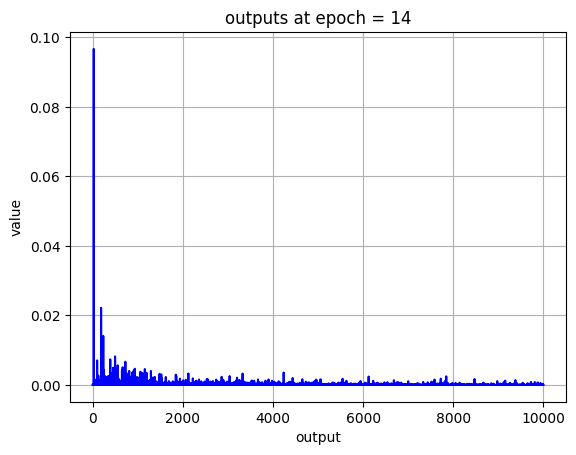

In [ ]:
output_softmax = F.softmax(outputs[5])


y = output_softmax.cpu()
y = y.detach().numpy()
print(np.sum(y))
print(y.shape)
plt.plot(np.arange(1,len(y)+1), y, label = 'outputs', color = 'blue')


#plt.legend()
plt.title(f'outputs at epoch = {epoch}')
#plt.ylim((0.75, 1))
plt.xlabel('output')
plt.ylabel('value')
plt.grid()
plt.show()

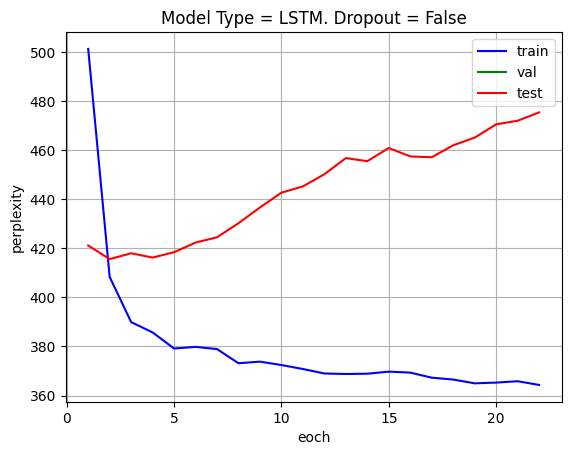

<Figure size 640x480 with 0 Axes>

In [ ]:
plot_results(results_m, f'{model.model_type} Dropout = {model.dropout != 0}.jpg')